## Import all necessary modules

In [1]:
import math,os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

## Prepare folder for data

In [2]:
# check if the folders for ExperimentalData exists; if not, create one
list_of_folders = ['AUTOCORRELATOR','OSA','OSCILLOSCOPE','RFSPECTRUM']
for i in list_of_folders:
    Path('./ExperimentalData/'+i+'/').mkdir(parents=True, exist_ok=True)


**Remember to place all data files in their corresponding folders before proceeding!**

## Read data in "ExperimentalData" folder

In [36]:
# assign path and make a list of all files in directory
# dirs will be the list of all folders (can use list_of_folders instead)....................................................................................................
path, dirs, files = next(os.walk("./ExperimentalData/"))
file_count = len(files)
Files=[]

# this is to keep track of the directories of all the data files
for i in range(len(dirs)):
    path, dis, files = next(os.walk("./ExperimentalData/"+dirs[i]))
    Files.append(files)
    file_count = file_count + len(files)

# create empty list
dataframes_list = []
 
# append datasets to the list 
for k in range(len(dirs)):
    for i in range(len(Files[k])):
        # checks the AUTOCORRELATOR folder for txt files then append 
        if dirs[k] == 'AUTOCORRELATOR' and Files[k][i].endswith('.txt'):
            data=[]
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as file:
                for line in file:
                    if line.startswith("#") == False:
                        line = line.strip().split('\t')
                        if is_number(line[0]):
                            data.append(float(x) for x in line)
                        else:
                            cname = line   
                temp_df = pd.DataFrame(data,columns=cname)
                temp_df.index = range(len(temp_df))
                # add normalisation into data (min-max feature scaling method)
                temp_df['NormInt'] = (temp_df['Intensity [arb.u.]'] - temp_df['Intensity [arb.u.]'].min()) \
                / (temp_df['Intensity [arb.u.]'].max() - temp_df['Intensity [arb.u.]'].min())
                temp_df['NormFit'] = (temp_df['Fit [arb.u.]'] - temp_df['Intensity [arb.u.]'].min()) \
                / (temp_df['Intensity [arb.u.]'].max() - temp_df['Intensity [arb.u.]'].min())
                row_index = (temp_df == 1).any(axis=1).idxmax()
                row = temp_df.loc[row_index]
                temp_df['Delay [ps]'] = temp_df['Delay [ps]'] - row['Delay [ps]']
                dataframes_list.append(temp_df)
        # checks the OSA folder for CSV files then append 
        elif dirs[k] == 'OSA' and Files[k][i].endswith('.CSV'):
            data = []
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as f:
                section = ''
                for line in f:
                    if line.strip() == '"[TRACE DATA]"':
                        section = 'data'
                    elif section == 'data':
                        data.append([float(x) for x in line.strip().split(',')])
                temp_df = pd.DataFrame(data, columns=['Wavelength', 'Intensity'])
                dataframes_list.append(temp_df)
        # checks the OSCILLOSCOPE folder for files then append 
        elif dirs[k] == 'OSCILLOSCOPE':
            data = []
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as f:
                for line in f:
                    line = line.strip().split(',')
                    if is_number(line[0]):
                        data.append([float(x) for x in line])
                temp_df = pd.DataFrame(data, columns=['Time (s)','Voltage (V)'])
                dataframes_list.append(temp_df)
        # checks the RFSPECTRUM folder for csv files then append 
        elif dirs[k] == 'RFSPECTRUM' and Files[k][i].endswith('.csv'):
            with open('./ExperimentalData/'+dirs[k]+'/'+Files[k][i]) as f:
                data=[]
                section = ''
                for line in f:
                    if line == '\n':
                        section = 'data'
                    elif section == 'data':
                        line = line.strip().split(',')
                        while('' in line):
                            line.remove('')
                        if is_number(line[0]):
                            data.append(float(x) for x in line)
                        else:
                            cname = line   
                temp_df = pd.DataFrame(data,columns=cname)
                temp_df = temp_df.drop([0])
                temp_df.index = range(len(temp_df))
                dataframes_list.append(temp_df)
            
# display datasets
for dataset in dataframes_list:
    display(dataset)

,Delay [ps],Intensity [arb.u.],Fit [arb.u.],NormInt,NormFit
0,27.360895,0.064432,0.06457,0.106669,0.10946
1,27.367667,0.064556,0.06457,0.109177,0.10946
2,27.374425,0.064675,0.06457,0.111583,0.10946
3,27.381170,0.064789,0.06457,0.113888,0.10946
4,27.387902,0.064898,0.06457,0.116092,0.10946
...,...,...,...,...,...
3995,-26.042364,0.063752,0.06457,0.092918,0.10946
3996,-26.049358,0.063895,0.06457,0.095810,0.10946
3997,-26.056339,0.064034,0.06457,0.098621,0.10946
3998,-26.063305,0.064171,0.06457,0.101391,0.10946


,Wavelength,Intensity
0,1850.0000,-69.867
1,1850.1001,-79.546
2,1850.2002,-71.213
3,1850.3003,-67.692
4,1850.4004,-68.438
...,...,...
995,1949.5996,-61.326
996,1949.6997,-61.495
997,1949.7998,-61.257
998,1949.8999,-61.359


,Time (s),Voltage (V)
0,-0.000170,0.000275
1,-0.000170,0.000474
2,-0.000170,0.000545
3,-0.000169,0.000397
4,-0.000169,0.000346
...,...,...
1995,0.000169,0.000409
1996,0.000169,0.000334
1997,0.000169,0.000407
1998,0.000170,0.000373


,Time (s),Voltage (V)
0,-2.400000e-07,0.005199
1,-2.398000e-07,0.002855
2,-2.396000e-07,0.000707
3,-2.394000e-07,-0.003395
4,-2.392000e-07,-0.007887
...,...,...
2395,2.390000e-07,-0.001832
2396,2.392000e-07,-0.001637
2397,2.394000e-07,-0.000855
2398,2.396000e-07,-0.000270


,Frequency [Hz],Maximum [dBm],Minimum [dBm]
0,1.315873e+06,-96.403259,-108.251648
1,1.631746e+06,-97.410179,-106.930893
2,1.947619e+06,-98.674179,-106.803574
3,2.263492e+06,-97.627541,-107.086960
4,2.579365e+06,-98.581665,-106.829559
...,...,...,...
625,1.987365e+08,-101.898582,-110.745033
626,1.990524e+08,-101.287231,-110.527809
627,1.993683e+08,-101.155312,-110.159370
628,1.996841e+08,-100.019577,-109.725288


<Axes: >

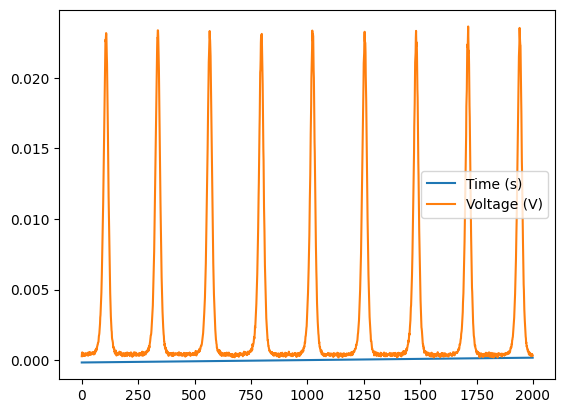

In [46]:
dataframes_list[2].plot()
